<a href="https://colab.research.google.com/github/BhanuTej14/project1/blob/master/Copy_of_Aerial_Image_Segmentation_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python
!pip install -U segmentation-models-pytorch
!pip install segmentation-models-pytorch --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.3 MB/s eta 0:00:00
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-m_xem8yu
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-m_xem8yu
  Resolved https://github.com/albumentations-team/albumentations to commit 66212d77a44927a29d6a0e81621d3c27afbd929c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.24
    Uninstalling albucore-0.0.24:
      Successfully uninstalled albucore-0.0.24
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 2.0.8 requires albucore==0.0.24, but you have albucore 0.0.28 which is incompatible.

# About Dataset

### Dataset

Here the dataset which we are going to use in this guided project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

### Full Dataset


https://www.cs.toronto.edu/~vmnih/data/

```
@phdthesis{MnihThesis,
author = {Volodymyr Mnih},
title = {Machine Learning for Aerial Image Labeling},
school = {University of Toronto},
year = {2013}
}
```

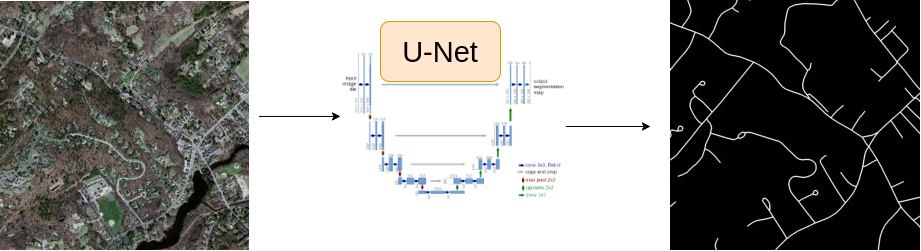

# Download Subset Dataset

In [ ]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

fatal: destination path 'Road_seg_dataset' already exists and is not an empty directory.


# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [ ]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

from segmentation_models_pytorch.losses import DiceLoss
import torch.nn as nn


# Task : 2 Setup Configurations

In [ ]:
CSV_FILE = '/content/Road_seg_dataset/train.csv'
DATA_DIR = '/content/Road_seg_dataset/'

DEVICE = 'cuda'

EPOCHS = 101
LR = 0.003
BATCH_SIZE = 8
IMG_SIZE =512

ENCODER = 'timm-effecientnet-b0'
WEIGHTS = 'imagenet'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [ ]:
idx = 15
row = df.iloc[idx]
image_path = DATA_DIR + row.images
mask_path = DATA_DIR + row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255

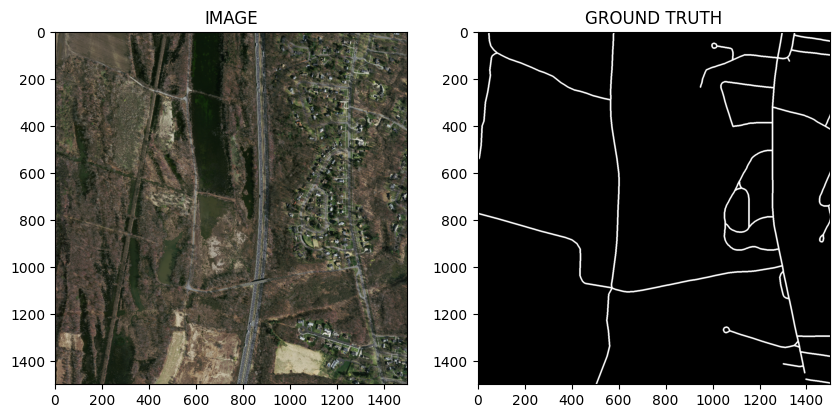

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df, valid_df = train_test_split(df, test_size=0.20, random_state=42)

In [ ]:
len(train_df), len(valid_df)

(159, 40)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.RandomGamma(p=0.3),
        A.Blur(blur_limit=3, p=0.2),
        A.HueSaturationValue(p=0.2),
        A.RandomFog(p=0.15),   # Use with **no arguments** for compatibility
        A.RandomRain(p=0.10),  # Default args only
        A.RandomSnow(p=0.10),  # Default args only
        A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])

def get_valid_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])

# Task 4 : Create Custom Dataset

In [ ]:
from torch.utils.data import Dataset

In [ ]:
from torch.utils.data import Dataset
from torch import Tensor # Import Tensor from torch
import torch
import cv2
import numpy as np
import os


class SegmentationDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(img_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_name = self.images[idx]
        image_path = os.path.join(self.img_dir, image_name)
        mask_path = os.path.join(self.mask_dir, image_name)

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 127).astype(np.float32)  # Binarize: 1 if >127, else 0

        if self.transform:
            data = self.transform(image=image, mask=mask)
            image = data['image']
            mask = data['mask']

        image = torch.Tensor(image).permute(2, 0, 1)  # Permute to [C, H, W]
        mask = torch.Tensor(mask).unsqueeze(0)  # shape: [1, H, W]

        return image, mask

In [ ]:
trainset = SegmentationDataset(
    img_dir='/content/Road_seg_dataset/images',
    mask_dir='/content/Road_seg_dataset/masks',
    transform=get_train_augs()
)
validset = SegmentationDataset(
    img_dir='/content/Road_seg_dataset/images',  # or a subfolder for val if you split images
    mask_dir='/content/Road_seg_dataset/masks',
    transform=get_valid_augs()
)



In [ ]:
print(f'There are {len(trainset)} images in the training set and {len(validset)} images in the validation set')

There are 199 images in the training set and 199 images in the validation set


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


idx = 3
image, mask = trainset[idx]
image_np = image.numpy().transpose(1,2,0)   # (H, W, 3)
mask_np = mask.numpy().squeeze()            # (H, W)


# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [ ]:
print(f'There are {len(trainloader)} batches in the training set and {len(validloader)} batches in the validation set')

There are 25 batches in the training set and 25 batches in the validation set


In [ ]:
for image, mask in trainloader:
  print(image.shape, mask.shape)
  break

torch.Size([8, 3, 512, 512]) torch.Size([8, 1, 512, 512])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

from torch import nn

In [ ]:
!pip install timm # Install timm library if you haven't already
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

from torch import nn

class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()
        self.backbone = smp.Unet(
            encoder_name='timm-efficientnet-b0',
            encoder_weights='imagenet',
            in_channels=3,
            classes=1,
            activation=None
        )

    def forward(self, images, masks=None):
        logits = self.backbone(images)
        if masks is not None:
            loss1 = DiceLoss(mode='binary')(logits, masks)
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            return logits, loss1 + loss2
        return logits

model = SegmentationModel()
model.to(DEVICE)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

SegmentationModel(
  (backbone): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (aa): Identity()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): S

In [ ]:
model = SegmentationModel()
model.to(DEVICE);

# Task 7 : Create Train and Validation Function

In [ ]:
def train_fn(trainloader, model, optimizer):
  model.train() #turn ON droupout, batchnorm, etc,..

  total_loss = 0
  for images, masks in tqdm(trainloader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(trainloader)

In [ ]:
def eval_fn(validloader, model):
  model.eval()
  total_loss = 0
  with torch.no_grad(): # Deactivate gradient calculation
    for images, masks in tqdm(validloader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)
      # Calculate loss without tracking gradients
      logits, loss = model(images, masks)
      total_loss += loss.item()
  # Return average loss over the validation set
  return total_loss / len(validloader)

# Task 8 : Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

In [ ]:
best_loss = float('inf')
patience_counter = 0
patience_limit = 7  # Early stopping patience

for epoch in range(1, 101):  # Train for up to 100 epochs
    train_loss = train_fn(trainloader, model, optimizer)
    valid_loss = eval_fn(validloader, model)
    scheduler.step(valid_loss)

    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pt')
        print('Saved Best Model!')
        patience_counter = 0
    else:
        patience_counter += 1
        print(f'No improvement for {patience_counter} epochs.')

    print(f'Epoch {epoch} - Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}')

    if patience_counter >= patience_limit:
        print("Early stopping triggered.")
        break

100%|██████████| 25/25 [00:19<00:00,  1.30it/s]


Saved Best Model!
Epoch 1 - Train Loss: 0.8226, Valid Loss: 0.7085


100%|██████████| 25/25 [00:18<00:00,  1.32it/s]


Saved Best Model!
Epoch 2 - Train Loss: 0.7906, Valid Loss: 0.6856


100%|██████████| 25/25 [00:19<00:00,  1.29it/s]


No improvement for 1 epochs.
Epoch 3 - Train Loss: 0.7608, Valid Loss: 0.6942


100%|██████████| 25/25 [00:19<00:00,  1.30it/s]


No improvement for 2 epochs.
Epoch 4 - Train Loss: 0.7463, Valid Loss: 0.7569


100%|██████████| 25/25 [00:19<00:00,  1.31it/s]


Saved Best Model!
Epoch 5 - Train Loss: 0.7375, Valid Loss: 0.6506


100%|██████████| 25/25 [00:19<00:00,  1.30it/s]


Saved Best Model!
Epoch 6 - Train Loss: 0.7193, Valid Loss: 0.6141


100%|██████████| 25/25 [00:19<00:00,  1.30it/s]


No improvement for 1 epochs.
Epoch 7 - Train Loss: 0.7192, Valid Loss: 0.6240


100%|██████████| 25/25 [00:18<00:00,  1.32it/s]


No improvement for 2 epochs.
Epoch 8 - Train Loss: 0.7011, Valid Loss: 0.6177


100%|██████████| 25/25 [00:19<00:00,  1.29it/s]


No improvement for 3 epochs.
Epoch 9 - Train Loss: 0.6996, Valid Loss: 0.6304


100%|██████████| 25/25 [00:19<00:00,  1.30it/s]


No improvement for 4 epochs.
Epoch 10 - Train Loss: 0.6818, Valid Loss: 0.6447


100%|██████████| 25/25 [00:18<00:00,  1.33it/s]


Saved Best Model!
Epoch 11 - Train Loss: 0.6938, Valid Loss: 0.6104


100%|██████████| 25/25 [00:19<00:00,  1.26it/s]


Saved Best Model!
Epoch 12 - Train Loss: 0.6656, Valid Loss: 0.5887


100%|██████████| 25/25 [00:19<00:00,  1.31it/s]


Saved Best Model!
Epoch 13 - Train Loss: 0.6711, Valid Loss: 0.5823


100%|██████████| 25/25 [00:19<00:00,  1.28it/s]


No improvement for 1 epochs.
Epoch 14 - Train Loss: 0.6574, Valid Loss: 0.5894


100%|██████████| 25/25 [00:18<00:00,  1.32it/s]


No improvement for 2 epochs.
Epoch 15 - Train Loss: 0.6679, Valid Loss: 0.5909


100%|██████████| 25/25 [00:19<00:00,  1.28it/s]


No improvement for 3 epochs.
Epoch 16 - Train Loss: 0.6623, Valid Loss: 0.6107


100%|██████████| 25/25 [00:18<00:00,  1.32it/s]


Saved Best Model!
Epoch 17 - Train Loss: 0.6497, Valid Loss: 0.5727


100%|██████████| 25/25 [00:19<00:00,  1.30it/s]


Saved Best Model!
Epoch 18 - Train Loss: 0.6496, Valid Loss: 0.5392


100%|██████████| 25/25 [00:18<00:00,  1.33it/s]


No improvement for 1 epochs.
Epoch 19 - Train Loss: 0.6539, Valid Loss: 0.5744


100%|██████████| 25/25 [00:19<00:00,  1.29it/s]


No improvement for 2 epochs.
Epoch 20 - Train Loss: 0.6535, Valid Loss: 0.5883


100%|██████████| 25/25 [00:19<00:00,  1.28it/s]


No improvement for 3 epochs.
Epoch 21 - Train Loss: 0.6471, Valid Loss: 0.5976


100%|██████████| 25/25 [00:18<00:00,  1.33it/s]


No improvement for 4 epochs.
Epoch 22 - Train Loss: 0.6495, Valid Loss: 0.5557


100%|██████████| 25/25 [00:19<00:00,  1.29it/s]


No improvement for 5 epochs.
Epoch 23 - Train Loss: 0.6367, Valid Loss: 0.5745


100%|██████████| 25/25 [00:19<00:00,  1.30it/s]


No improvement for 6 epochs.
Epoch 24 - Train Loss: 0.6389, Valid Loss: 0.5780


100%|██████████| 25/25 [00:19<00:00,  1.31it/s]

No improvement for 7 epochs.
Epoch 25 - Train Loss: 0.6398, Valid Loss: 0.5736
Early stopping triggered.


# Task 9 : Inference

In [ ]:
idx = 101  # Change this value to a valid index within the range of your dataset

# Check the length of your validset
print(len(validset))

# Ensure idx is within the valid range
if idx >= len(validset):
  idx = len(validset) - 1  # Set idx to the last valid index
  print(f"idx is out of bounds. Setting idx to the last valid index: {idx}")

model.load_state_dict(torch.load('best_model.pt'))
image, mask = validset[idx]
logits_mask = model(image.to(DEVICE).unsqueeze(0))  #(c,h,w) --> (b,c,h,w)

pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0

199


In [ ]:
##helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0)) # Remove one squeeze(0) call

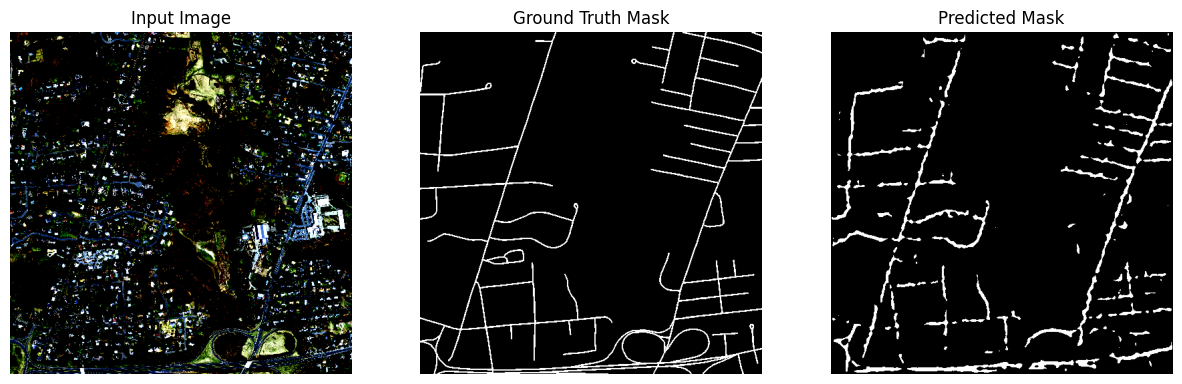

In [ ]:
import matplotlib.pyplot as plt

def show_image(image, mask, pred_mask):
    """Display image, mask, and predicted mask side by side."""
    image_np = image.numpy().transpose(1, 2, 0)
    mask_np = mask.numpy().squeeze()
    pred_mask_np = pred_mask.numpy().squeeze()

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(image_np)
    axes[0].set_title('Input Image')
    axes[0].axis('off')

    axes[1].imshow(mask_np, cmap='gray')
    axes[1].set_title('Ground Truth Mask')
    axes[1].axis('off')

    axes[2].imshow(pred_mask_np, cmap='gray')
    axes[2].set_title('Predicted Mask')
    axes[2].axis('off')

    plt.show()

# Usage example
show_image(image, mask, pred_mask.detach().cpu())


In [ ]:
idx = 10  # Example index
image, mask = validset[idx]
input_img = image.unsqueeze(0).to(DEVICE)  # shape: [1, 3, H, W]
mask = mask.squeeze().cpu()  # shape: [H, W]

model.eval()
with torch.no_grad():
    pred_logits = model(input_img)
    pred_prob = torch.sigmoid(pred_logits)
    pred_mask_bin = (pred_prob > 0.5).float().squeeze().cpu()  # shape: [H, W]

def dice_score(pred, target):
    pred_flat = pred.view(-1)
    target_flat = target.view(-1)
    intersection = (pred_flat * target_flat).sum()
    return 2. * intersection / (pred_flat.sum() + target_flat.sum() + 1e-8)

score = dice_score(pred_mask_bin, mask)
print("Dice Score:", score.item())


Dice Score: 0.2626689374446869


In [ ]:
idx = 100  # Change this value to a valid index within the range of your dataset

# Check the length of your validset
print(len(validset))

# Ensure idx is within the valid range
if idx >= len(validset):
  idx = len(validset) - 1  # Set idx to the last valid index
  print(f"idx is out of bounds. Setting idx to the last valid index: {idx}")

model.load_state_dict(torch.load('best_model.pt'))
image, mask = validset[idx]
logits_mask = model(image.to(DEVICE).unsqueeze(0))  #(c,h,w) --> (b,c,h,w)

pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0

199


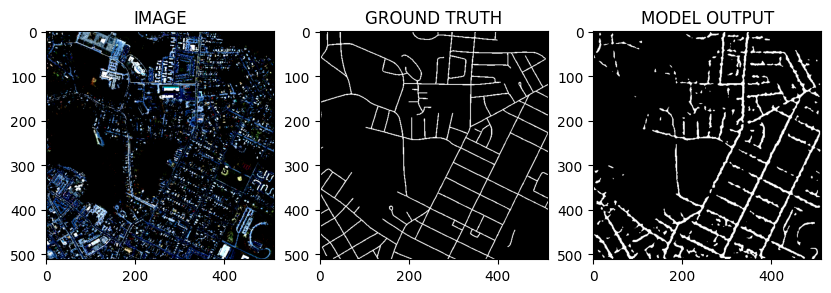

In [ ]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0)) # Remove one squeeze(0) call